In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 10 10:40:00 2017

@author: ncaplar@princeton.edu

"""
%connect_info

{
  "stdin_port": 61671, 
  "ip": "127.0.0.1", 
  "control_port": 61672, 
  "hb_port": 61673, 
  "signature_scheme": "hmac-sha256", 
  "key": "f16015fb-e00df96c518c13e8edb2d8c2", 
  "kernel_name": "", 
  "shell_port": 61669, 
  "transport": "tcp", 
  "iopub_port": 61670
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c2705842-76c0-4d9e-b3ee-d7721e39efcf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

# Data 

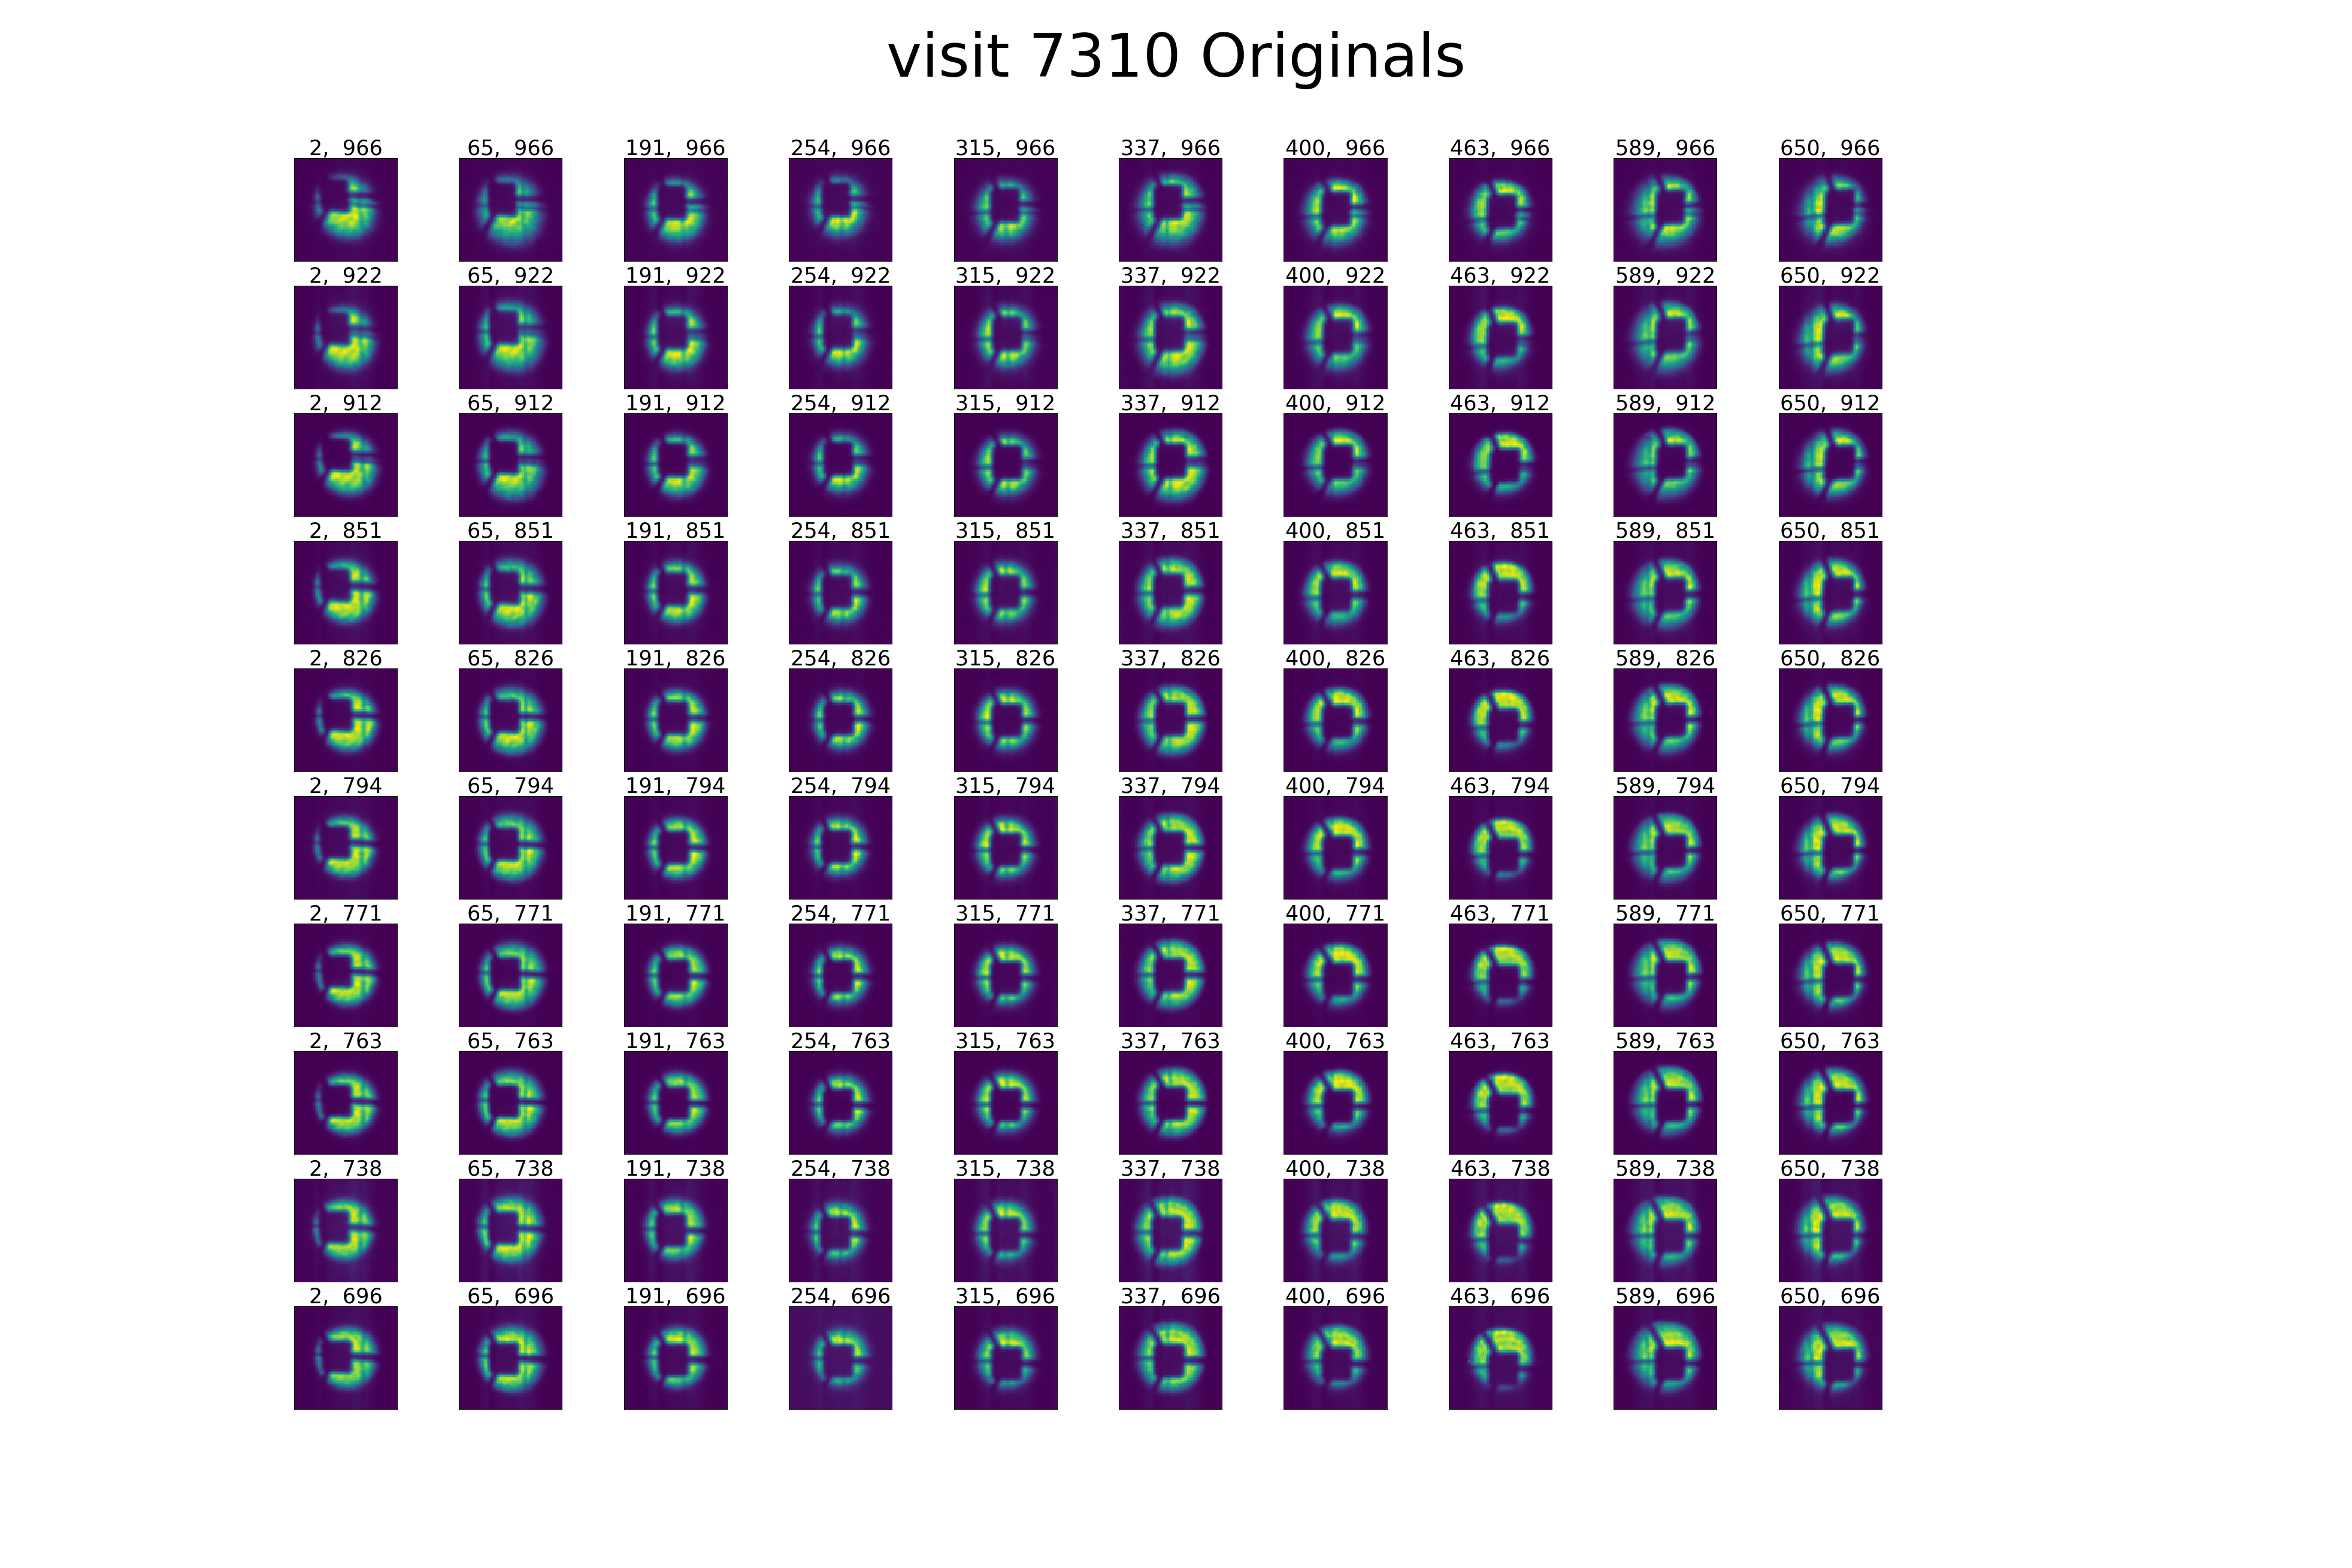

In [7]:
from IPython.display import Image
Image(filename='/Users/nevencaplar/Documents/PFS/Images/France/7310 Originals.png') 

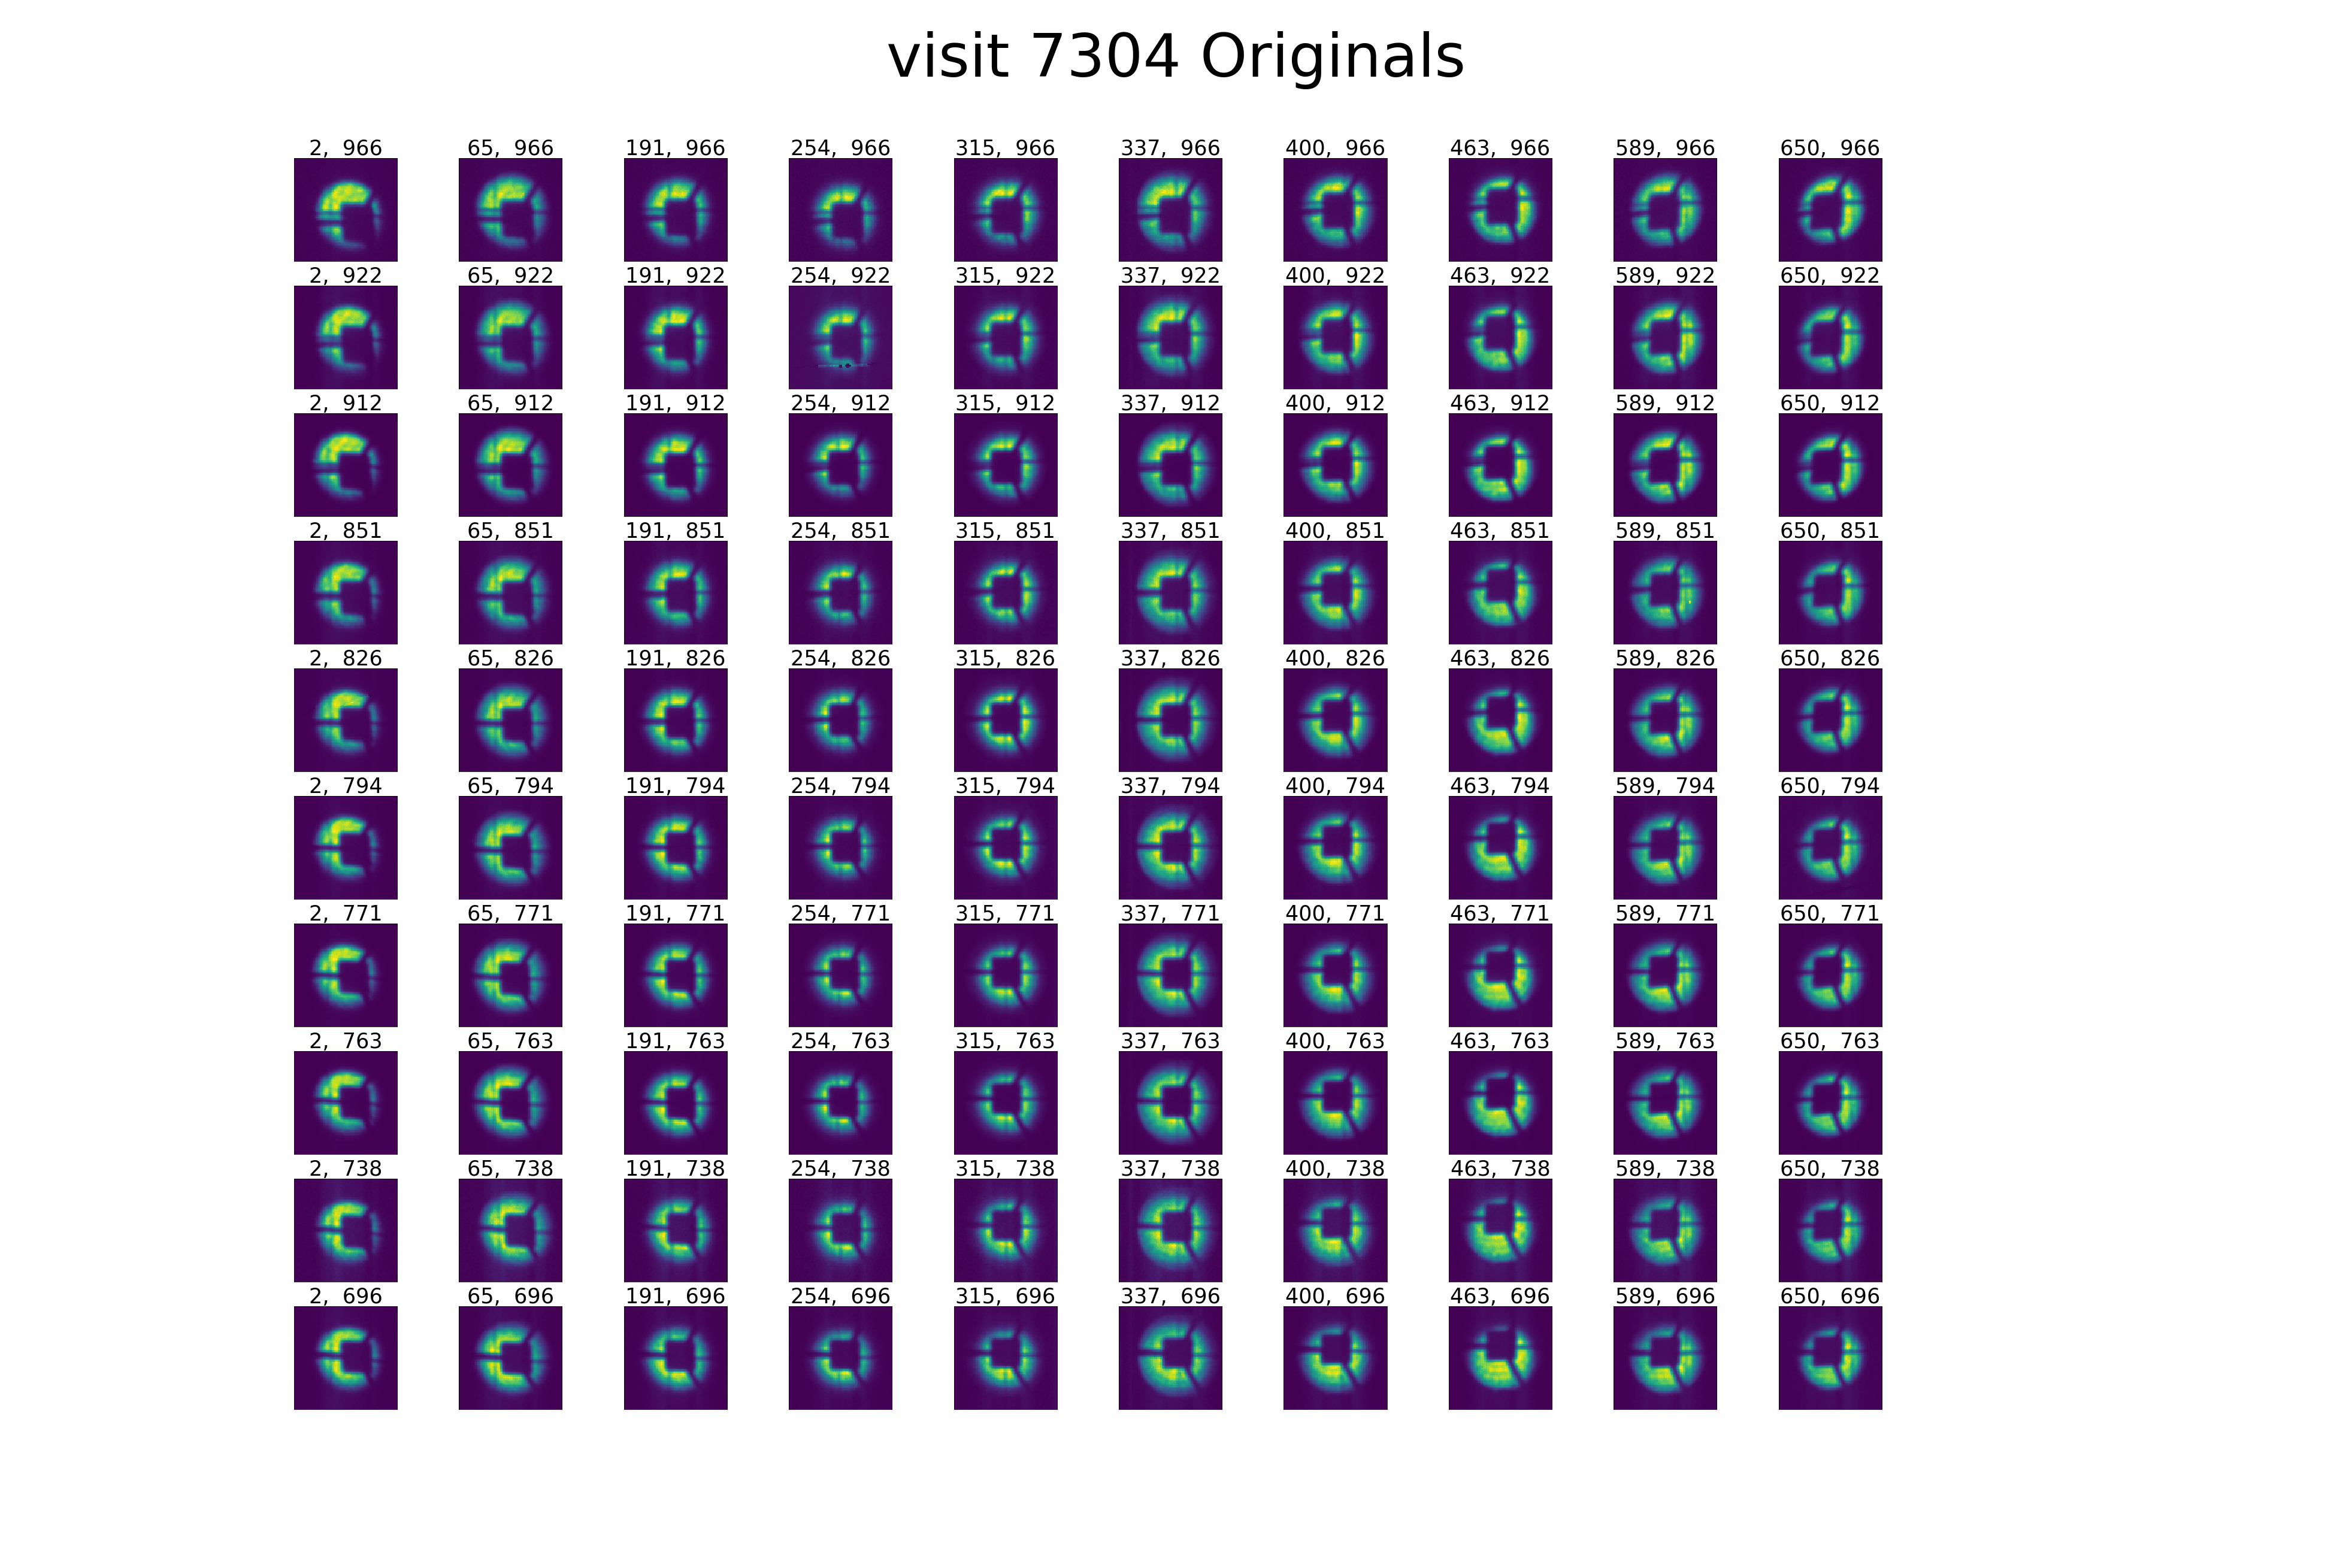

In [8]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/France/7304 Originals.png') 

# Model

In [9]:
#import statments
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

#np.seterr(divide='ignore', invalid='ignore')

In [10]:
#__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,illumminatedFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,illumminatedFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = (self.pupilSize/2)*self.illumminatedFrac

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [11]:
# ZernikeFitter
class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    The centroid parameters are also free parameters.
    Note that to create the images, the parameters must be initialized with the
    `.initParams` method.
    
    This code uses lmfit to initalize the parameters. This is a relic of the code
    in which this class was used to actually fit the parameters
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,
                 jacobian=None,nonUniformEffect=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds (this is spectroscop)
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        """
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        # Note that this is a spectroscop and not an normal optical telescope,
        #so this is not real physical quantity
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        # Again, wavelength - this is a spectroscop
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        if nonUniformEffect is None:
            nonUniformEffect==False
        
        self.kwargs = kwargs
    
    def initParams(self, zmax=4, z4Init=None, centroidInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,diam_sicInit=None,fiber_rInit=None,flux_multInit=None,
                  npixInit=None,side_of_focusInit=None):
        """Initialize lmfit Parameters object.
        @param zmax                 Total number of Zernike aberrations used
        @param z4Init               Initial Z4 aberration value in waves.
        @param centroidInit         2-tuple for the position of the center of the spot in the image.
        @param hscFracInit          Fraction of the pupil obscuraded by the camera ()
        @param strutFracInit        Fraction of the pupil obscuraded by the single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(camera) in the focal plane
        @param diam_sicInit         Size of the telescope in meters
        @param fiber_rInit          Factor that determines the size of the input fiber
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if centroidInit is None:
            params.add('dx', 0.0)
            params.add('dy', 0.0)
        else:
            params.add('dx', centroidInit[0])
            params.add('dy', centroidInit[1])   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1]) 
            
        if diam_sicInit is None:
            params.add('diam_sic', 3.3)
        else:
            params.add('diam_sic', diam_sicInit)   
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
            
        if flux_multInit is None:
            params.add('flux_mult', 1)
        else:
            params.add('flux_mult', flux_multInit)    
        
        if npixInit is None:
            params.add('npix', 512)
        else:
            params.add('npix', npixInit)    
            
        if side_of_focusInit is None:
            params.add('side_of_focus', 1)
        else:
            params.add('side_of_focus', side_of_focusInit)                
        
        params.add('illumminatedFrac',0.96)        
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        Pupil_Image=PFSPupilFactory(params['diam_sic'.format(i)],params['npix'.format(i)],
                                    params['side_of_focus'.format(i)]*np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],
                                  params['illumminatedFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params,pad_factor=1.5)

    def constructModelImage_PFS(self,params=None,shape=None,pixelScale=None,jacobian=None,nonUniformEffect=False):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param jacobian    An optional 2x2 Jacobian distortion matrix to apply
                           to the forward model.  Note that this is relative to
                           the pixelScale above.  Use self.jacobian if this is
                           None.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)


        #This creates opticalpsf
        if nonUniformEffect==False:
            # 1 component
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
                
                
            optPsf=self._getOptPsf(v)
            optPsf = optPsf.shift(v['dx'], v['dy'])
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
            final = galsim.Convolve([gal, optPsf])
            modelImg = final.drawImage(
            nx = shape[0],
            ny = shape[1],
            wcs = wcs)
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg.array
        else:
            # 3 components
            try:
                v = params.valuesdict()
            except AttributeError:
                v = params
            
                        
            v['illumminatedFrac']=0.96
            optPsf1=self._getOptPsf(v)
            optPsf1 = optPsf1.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=0.986
            optPsf2=self._getOptPsf(v)
            optPsf2 = optPsf2.shift(v['dx'], v['dy'])
            v['illumminatedFrac']=1
            optPsf3=self._getOptPsf(v)
            optPsf3 = optPsf3.shift(v['dx'], v['dy'])
            
            wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
            gal1 = galsim.TopHat(flux=0.32, radius=(3/8)*(3/2)*v['fiber_r'])
            gal2 = galsim.TopHat(flux=0.334, radius=(3/8)*(3/2)*v['fiber_r'])
            gal3 = galsim.TopHat(flux=0.346, radius=(3/8)*(3/2)*v['fiber_r'])
            
            final1 = galsim.Convolve([gal1, optPsf1])
            final2 = galsim.Convolve([gal2, optPsf2])
            final3 = galsim.Convolve([gal3, optPsf3])
            
            modelImg1 = final1.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg2 = final2.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            modelImg3 = final3.drawImage(nx = shape[0],ny = shape[1],wcs = wcs)
            
            modelImg=np.add(np.add(modelImg1.array,modelImg2.array),modelImg3.array)
            
            multiplicative_factor=self.flux*v['flux_mult']
            return multiplicative_factor*modelImg

    
    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
    
    
    
    
    
    
    
# I think I do not need anything below
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

## No Zernike components

In [16]:
single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=4)
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  

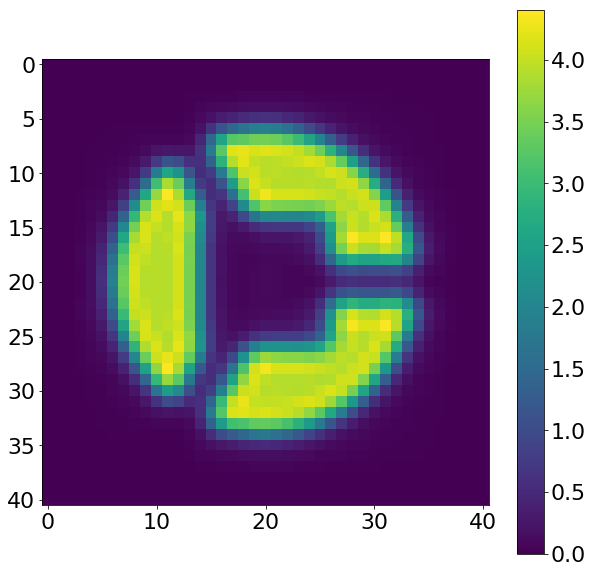

In [50]:
plt.figure(figsize=(8,8))
plt.imshow(best_img)
plt.colorbar()

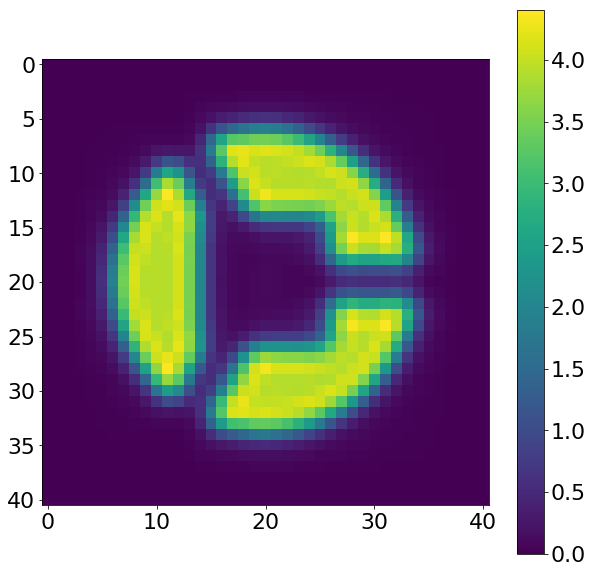

In [51]:
plt.figure(figsize=(8,8))
x=[8,0,0,0.8,0.2,0,0,1,1]
single_image_analysis.params['z4'].set(x[0])        
single_image_analysis.params['dx'].set(x[1])
single_image_analysis.params['dy'].set(x[2])
single_image_analysis.params['hscFrac'].set(x[3])
single_image_analysis.params['strutFrac'].set(x[4])
single_image_analysis.params['dxFocal'].set(x[5])
single_image_analysis.params['dyFocal'].set(x[6])
single_image_analysis.params['fiber_r'].set(x[7])
single_image_analysis.params['flux_mult'].set(x[8])
single_image_analysis.params['npix'].set(256)
single_image_analysis.params['side_of_focus'].set(1)
single_image_analysis.params['diam_sic'].set(3.3) 
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params)  
plt.imshow(best_img)
plt.colorbar()

### Pupil 

In [39]:
Pupil_data=PFSPupilFactory(single_image_analysis.params['diam_sic'].value,
                           single_image_analysis.params['npix'],
                           single_image_analysis.params['side_of_focus']*np.pi/2,
                           single_image_analysis.params['hscFrac'].value,
                           single_image_analysis.params['strutFrac'].value,0.96)
point=Point2D(single_image_analysis.params['dxFocal'].value,
          single_image_analysis.params['dyFocal'].value)
pupil=Pupil_data.getPupil(point)

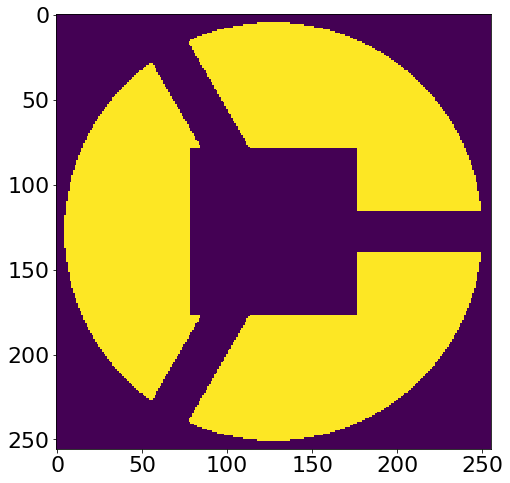

In [53]:
plt.figure(figsize=(8,8))
plt.imshow(pupil.illuminated)

## Up to Zernike 11

### Zernike - Wiki image

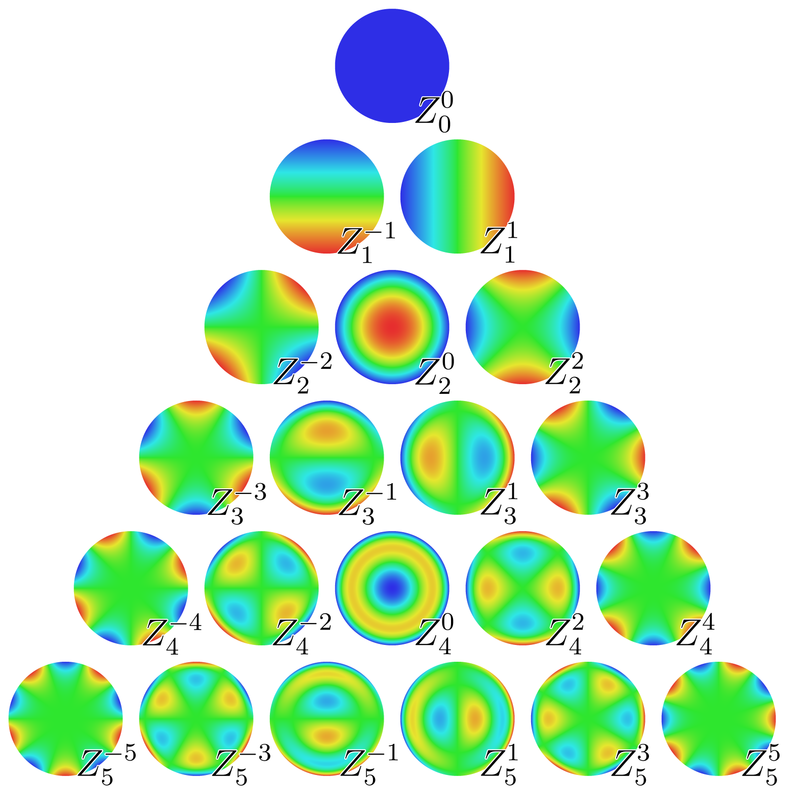

In [35]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/800px-Zernike_polynomials2.png') 

### Examples of Zernike effects

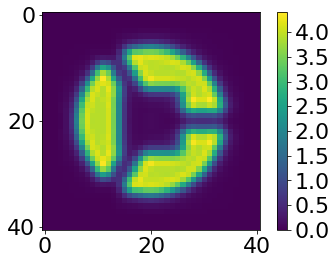

In [49]:
plt.figure(figsize=(8,8))
x=[8,0,0,0,0,0,0,0,0,0,0.8,0.2,0,0,1,1]
single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=11)
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['fiber_r'].set(x[14])
single_image_analysis.params['flux_mult'].set(x[15])
single_image_analysis.params['npix'].set(256)
single_image_analysis.params['side_of_focus'].set(1)  
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

#### z5

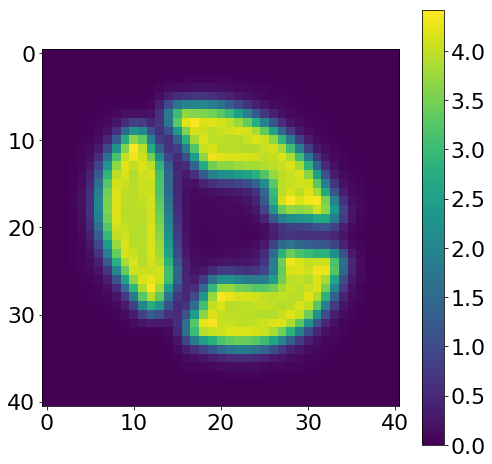

In [55]:
plt.figure(figsize=(8,8))
single_image_analysis.params['z5'].set(1)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

#### z6

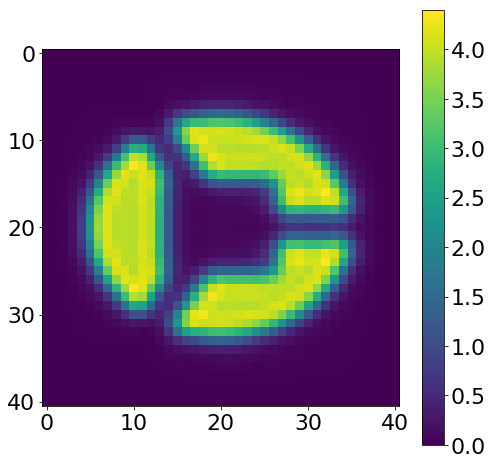

In [56]:
plt.figure(figsize=(8,8))
single_image_analysis.params['z5'].set(0)
single_image_analysis.params['z6'].set(1)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

#### z7

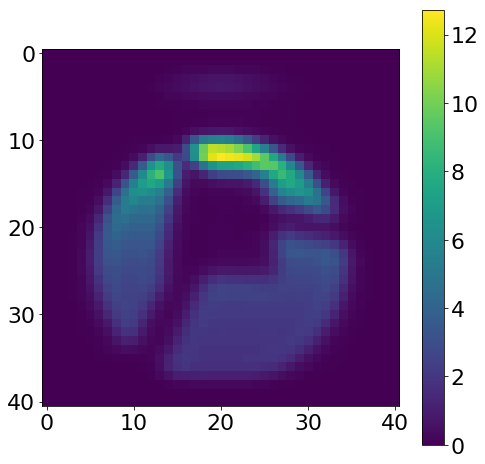

In [60]:
plt.figure(figsize=(8,8))
single_image_analysis.params['z6'].set(0)
single_image_analysis.params['z7'].set(1)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

#### z9

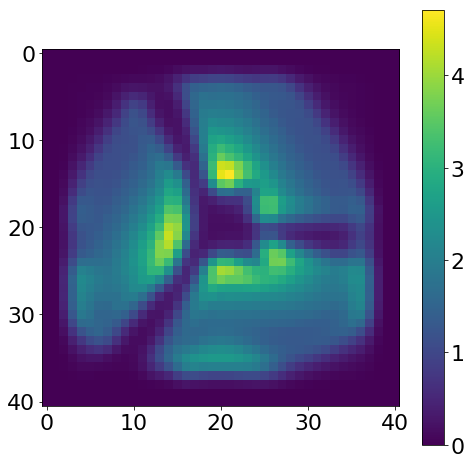

In [70]:
plt.figure(figsize=(8,8))
single_image_analysis.params['z7'].set(0)
single_image_analysis.params['z9'].set(1)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

## Up to Zernike 22

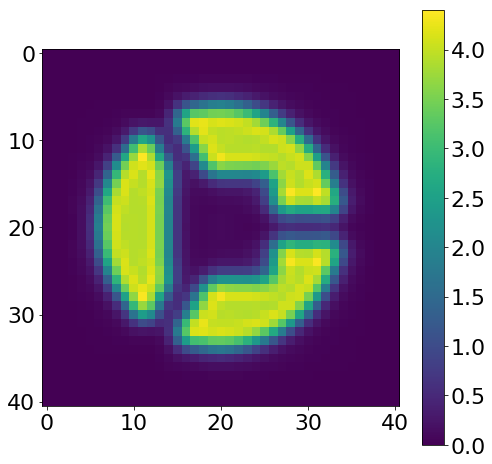

In [72]:
plt.figure(figsize=(8,8))
x=[8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8,0.2,0,0,1,1]
single_image_analysis=ZernikeFitter_PFS()
single_image_analysis.initParams(zmax=22)
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['diam_sic'].set(3.3)  
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['z12'].set(x[8])
single_image_analysis.params['z13'].set(x[9])
single_image_analysis.params['z14'].set(x[10])
single_image_analysis.params['z15'].set(x[11])
single_image_analysis.params['z16'].set(x[12])
single_image_analysis.params['z17'].set(x[13])
single_image_analysis.params['z18'].set(x[14])
single_image_analysis.params['z19'].set(x[15])      
single_image_analysis.params['z20'].set(x[16])
single_image_analysis.params['z21'].set(x[17]) 
single_image_analysis.params['z22'].set(x[18]) 
single_image_analysis.params['dx'].set(x[19])
single_image_analysis.params['dy'].set(x[20])
single_image_analysis.params['hscFrac'].set(x[21])
single_image_analysis.params['strutFrac'].set(x[22])
single_image_analysis.params['dxFocal'].set(x[23])
single_image_analysis.params['dyFocal'].set(x[24])
single_image_analysis.params['fiber_r'].set(x[25])
single_image_analysis.params['flux_mult'].set(x[26])
single_image_analysis.params['npix'].set(256)
single_image_analysis.params['side_of_focus'].set(1)  
best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

### Example(s)

#### z19

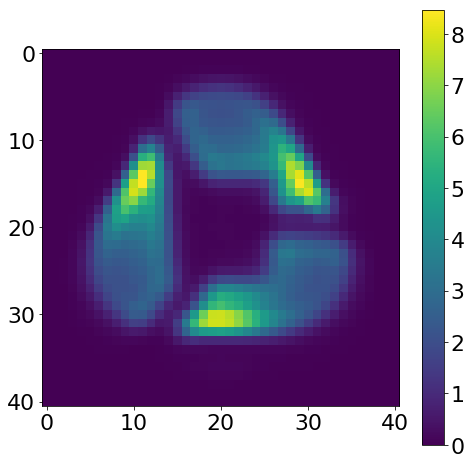

In [75]:
plt.figure(figsize=(8,8))
single_image_analysis.params['z19'].set(0.3)

best_img=single_image_analysis.constructModelImage_PFS(single_image_analysis.params) 
plt.imshow(best_img)
plt.colorbar()

# Fitting - not finished 

In [99]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [103]:
i=66
test_img_defocus=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy')
test_img_model_defocus=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Model/'+str(int(i))+'.npy')

In [104]:
print('x positions is: '+str(single_number_for_single_pos_full[np.where(single_number_for_single_pos_full[:,0]==i)][0][3]))
print('y positions is: '+str(4175-single_number_for_single_pos_full[np.where(single_number_for_single_pos_full[:,0]==i)][0][3]))

x positions is: 2078.0
y positions is: 2097.0


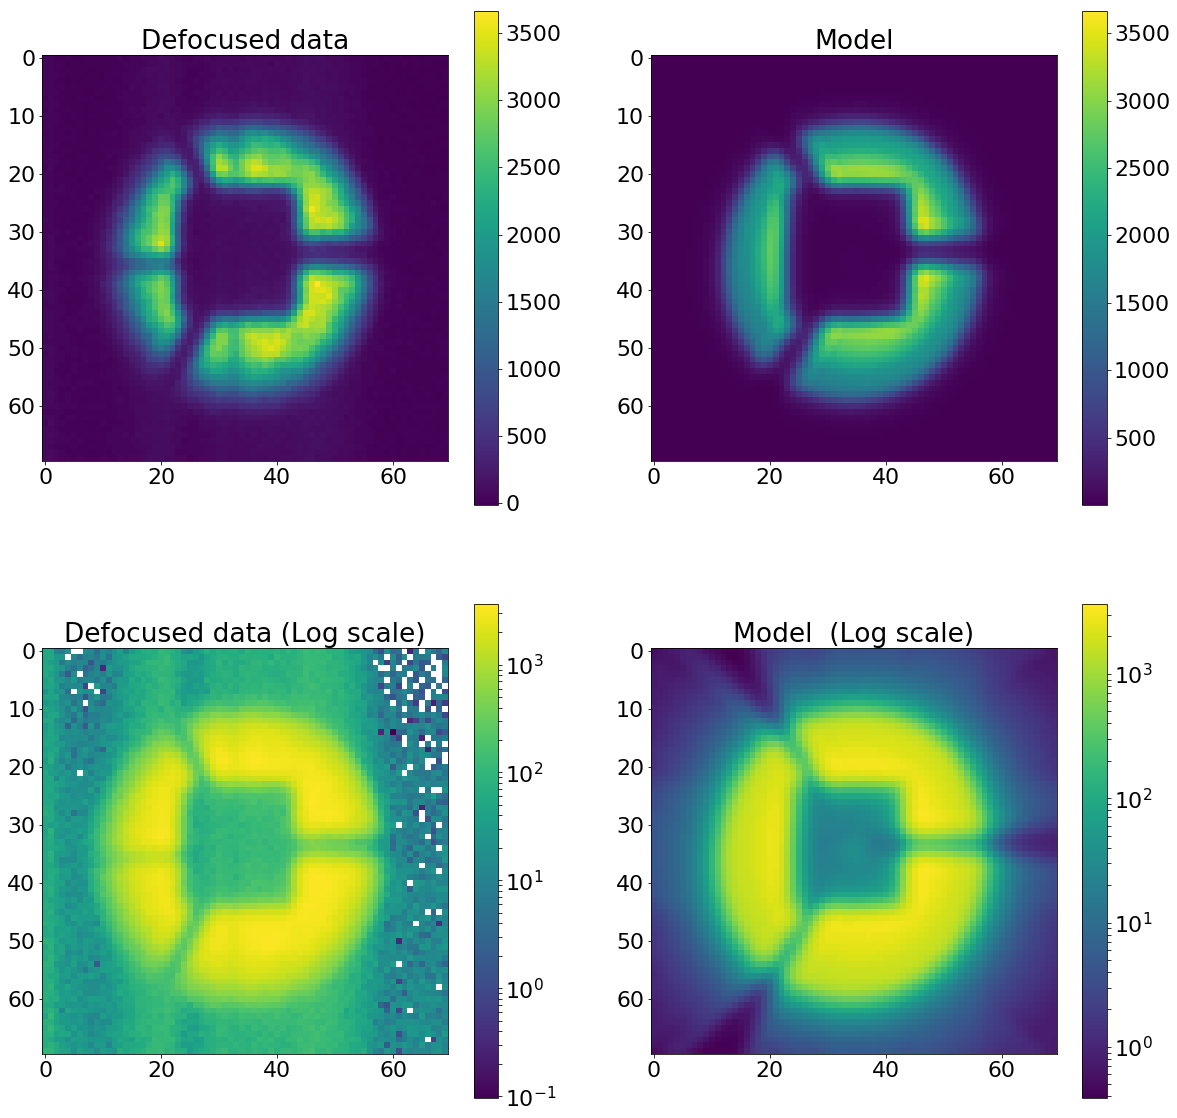

In [112]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(test_img_defocus)
plt.colorbar()
plt.title('Defocused data')

plt.subplot(222)
plt.imshow(test_img_model_defocus,vmax=np.max(test_img_defocus))
plt.colorbar()
plt.title('Model')

plt.subplot(223)
plt.imshow(test_img_defocus,norm=LogNorm())
plt.colorbar()
plt.title('Defocused data (Log scale)')

plt.subplot(224)
plt.imshow(test_img_model_defocus,vmax=np.max(test_img_defocus),norm=LogNorm())
plt.colorbar()
plt.title('Model  (Log scale)')



In [115]:
i=66
test_img_residual=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Residual/'+str(int(i))+'.npy')
test_img_chi=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Chi/'+str(int(i))+'.npy')

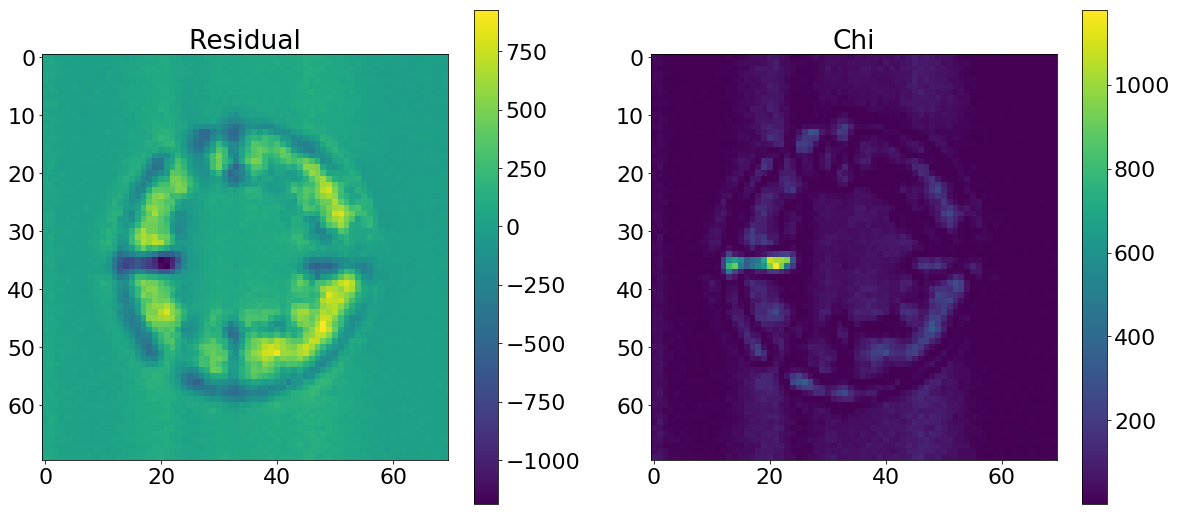

In [119]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(test_img_residual)
plt.colorbar()
plt.title('Residual')

plt.subplot(222)
plt.imshow(test_img_chi)
plt.colorbar()
plt.title('Chi')

plt.savefig("/Users/nevencaplar/Documents/PFS/Images/SlitChi.png")

# Results across the chip - not finished 

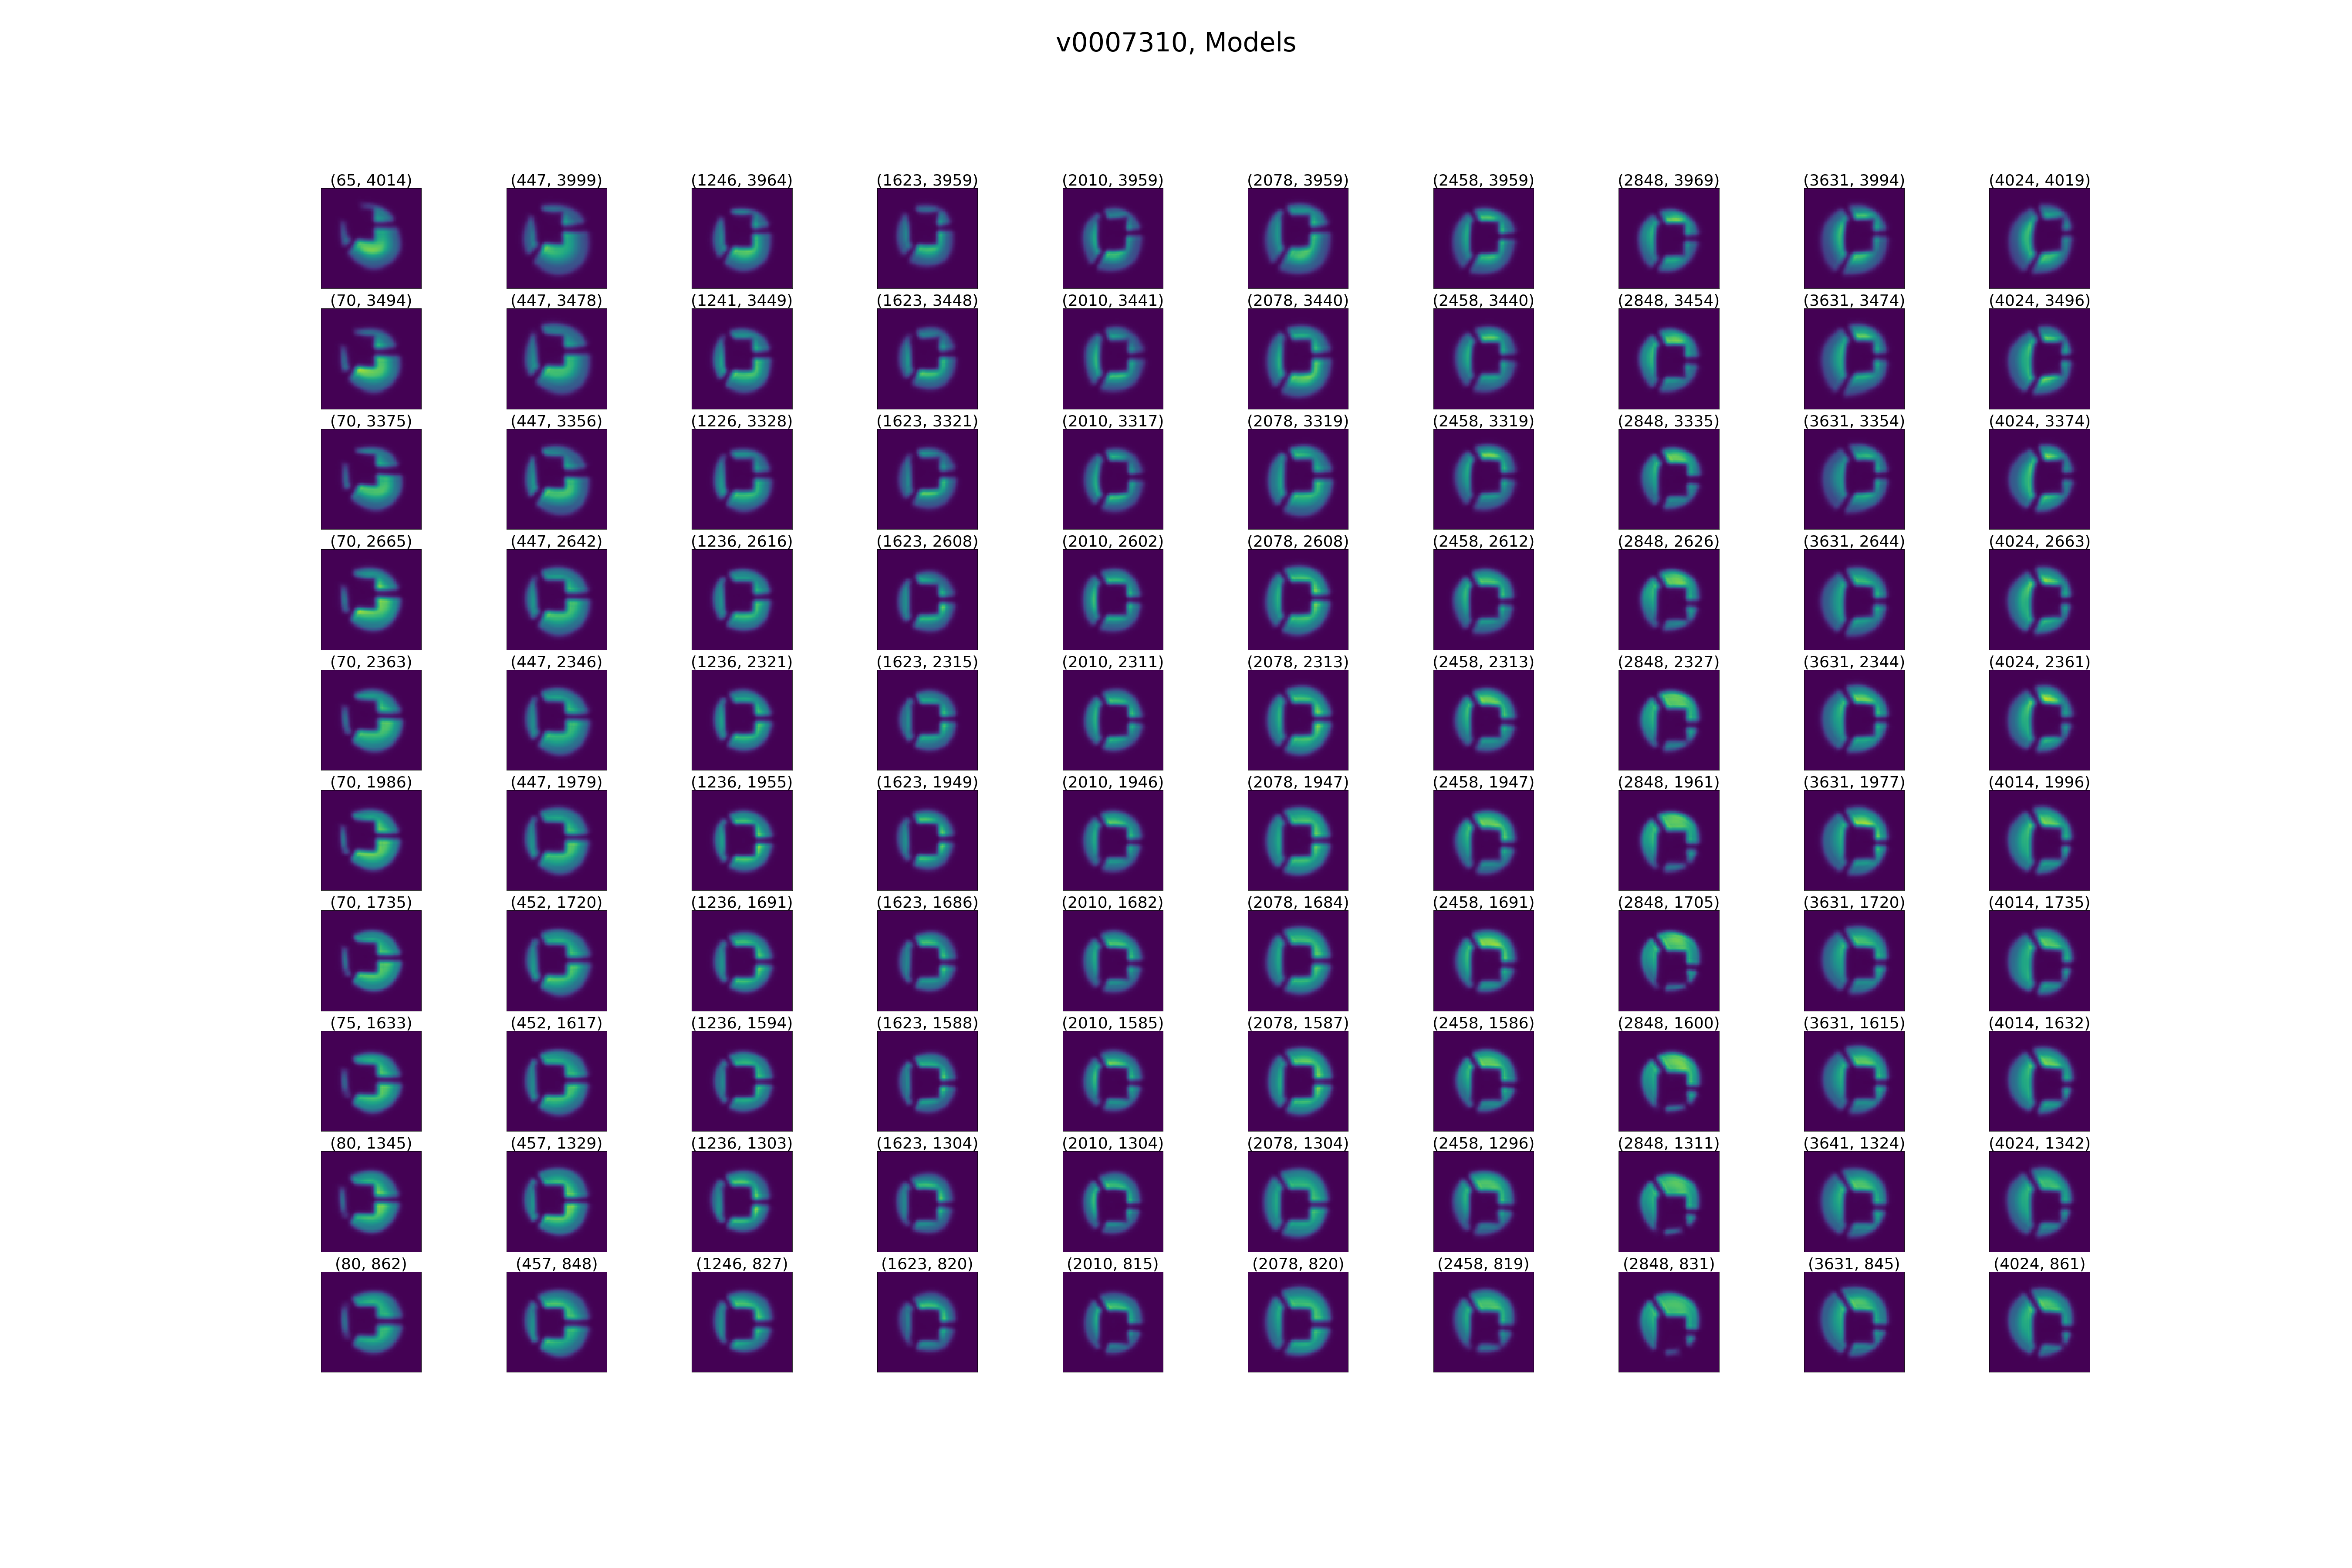

In [97]:
# Status on November 10, 2017
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/Models.png') 

## Zernike

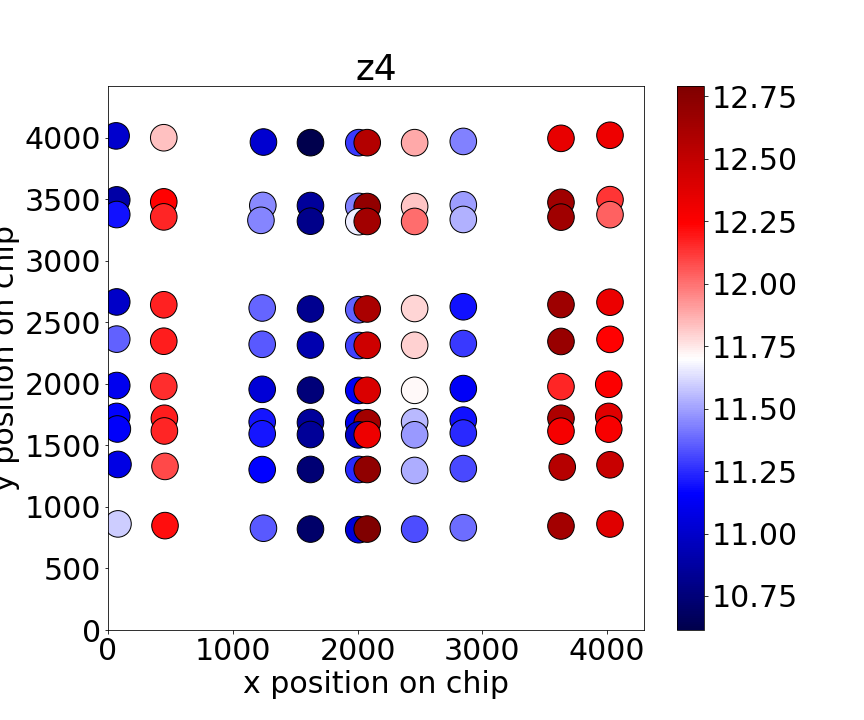

In [96]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/0_z4.png') 

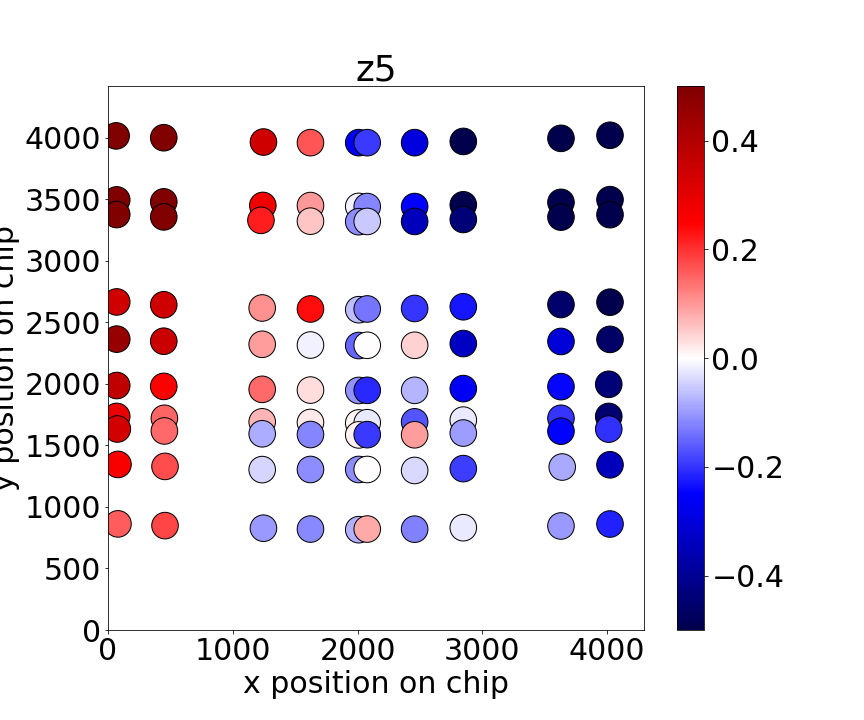

In [120]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/1_z5.png') 

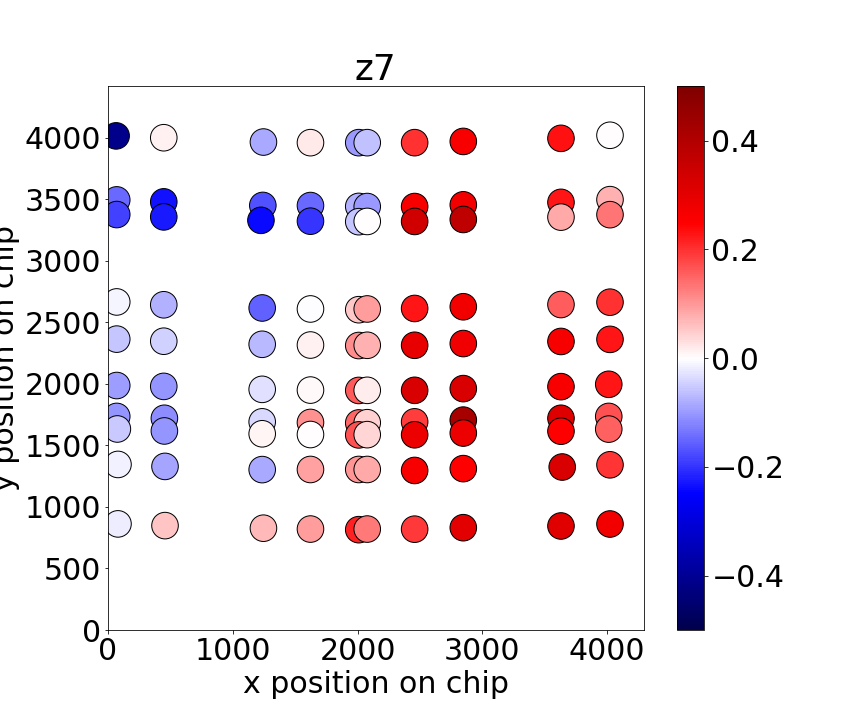

In [121]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/3_z7.png') 

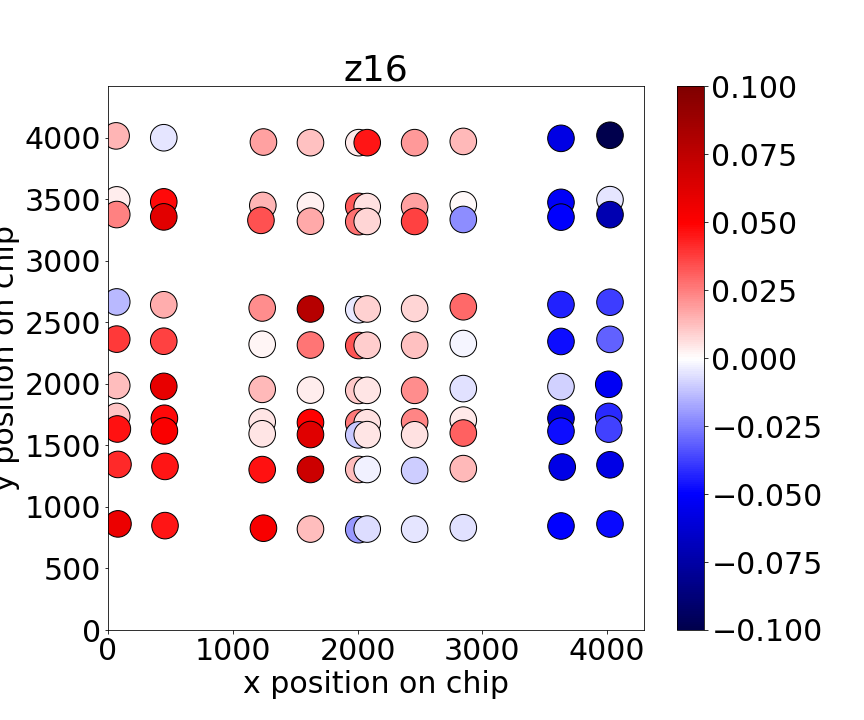

In [122]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/12_z16.png') 

## Pupil parameters

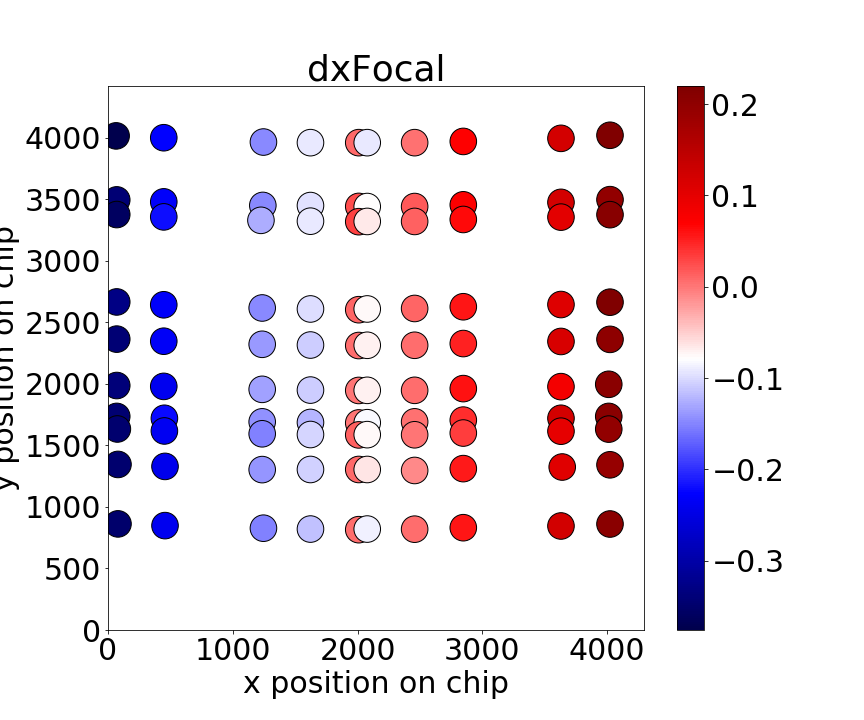

In [124]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/23_dxFocal.png') 

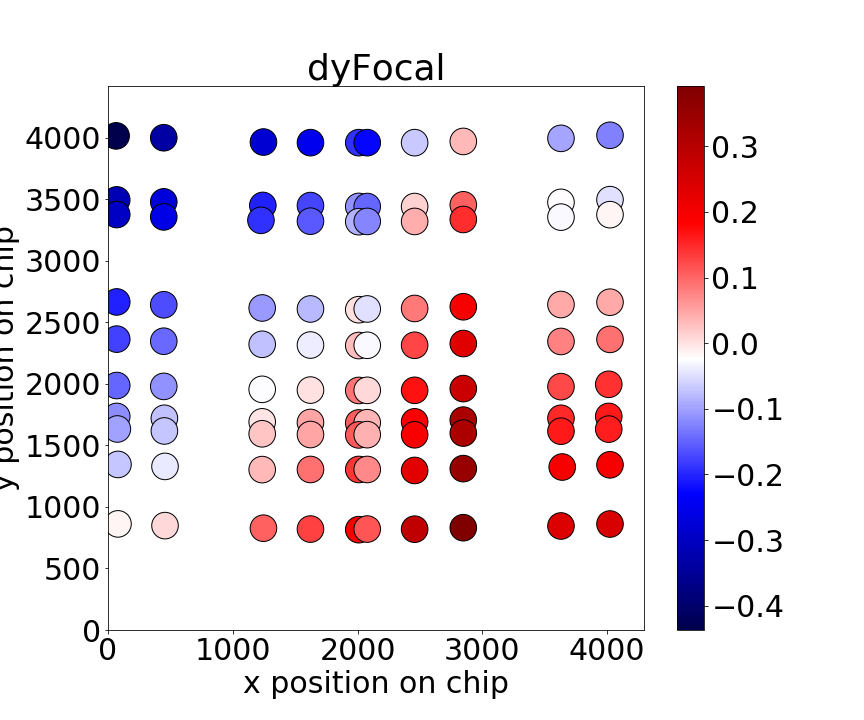

In [125]:
Image(filename='/Users/nevencaplar/Documents/PFS/Images/Nov09/z22/Summary/24_dyFocal.png') 

# Predicting focused - not finished 

In [81]:
single_number_for_single_pos_full=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Nov09/7310single_number_for_single_pos_full.npy") 
single_donut_objects_index=single_number_for_single_pos_full[:,0]

In [77]:
i=66
test_img=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7296'+str(int(i))+'.npy')
pos_of_max_flux=np.where(test_img==np.max(test_img))
pos_of_max_flux=map(int,pos_of_max_flux)
test_img_zoom=test_img[pos_of_max_flux[0]-6:pos_of_max_flux[0]+7,pos_of_max_flux[1]-6:pos_of_max_flux[1]+7]
test_img_zoom_flux=np.sum(test_img_zoom)

test_img_defocus=np.load('/Users/nevencaplar/Documents/PFS/Images/Nov09/Original/sci7310'+str(int(i))+'.npy')

In [93]:
print('x positions is: '+str(single_number_for_single_pos_full[np.where(single_number_for_single_pos_full[:,0]==i)][0][3]))
print('y positions is: '+str(4175-single_number_for_single_pos_full[np.where(single_number_for_single_pos_full[:,0]==i)][0][3]))

x positions is: 2078.0
y positions is: 2097.0


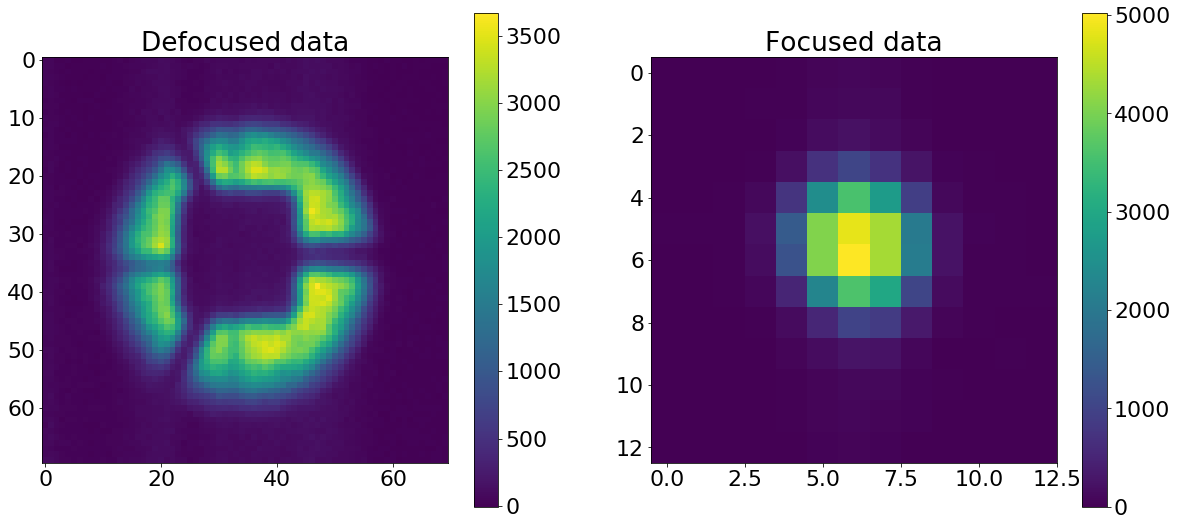

In [94]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img_defocus)
plt.colorbar()
plt.title('Defocused data')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img_zoom)
plt.colorbar()
plt.title('Focused data')
plt.grid(False)

In [1]:
res

NameError: name 'res' is not defined